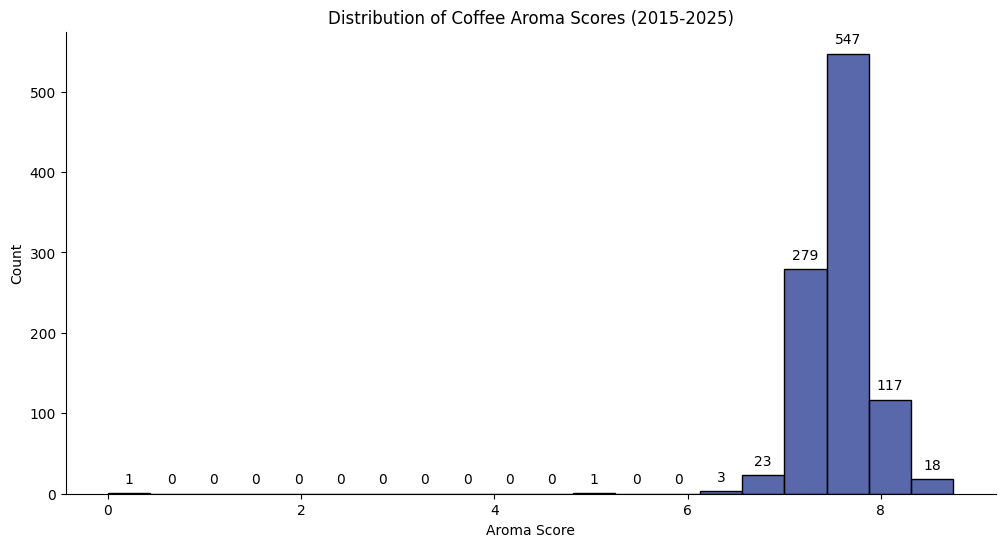

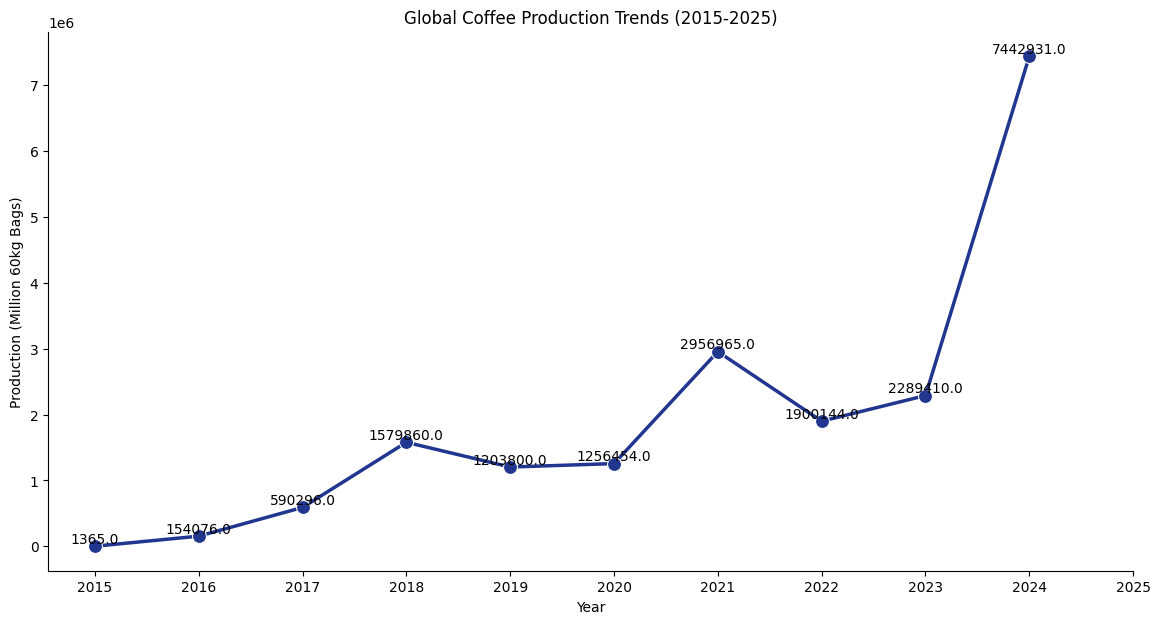

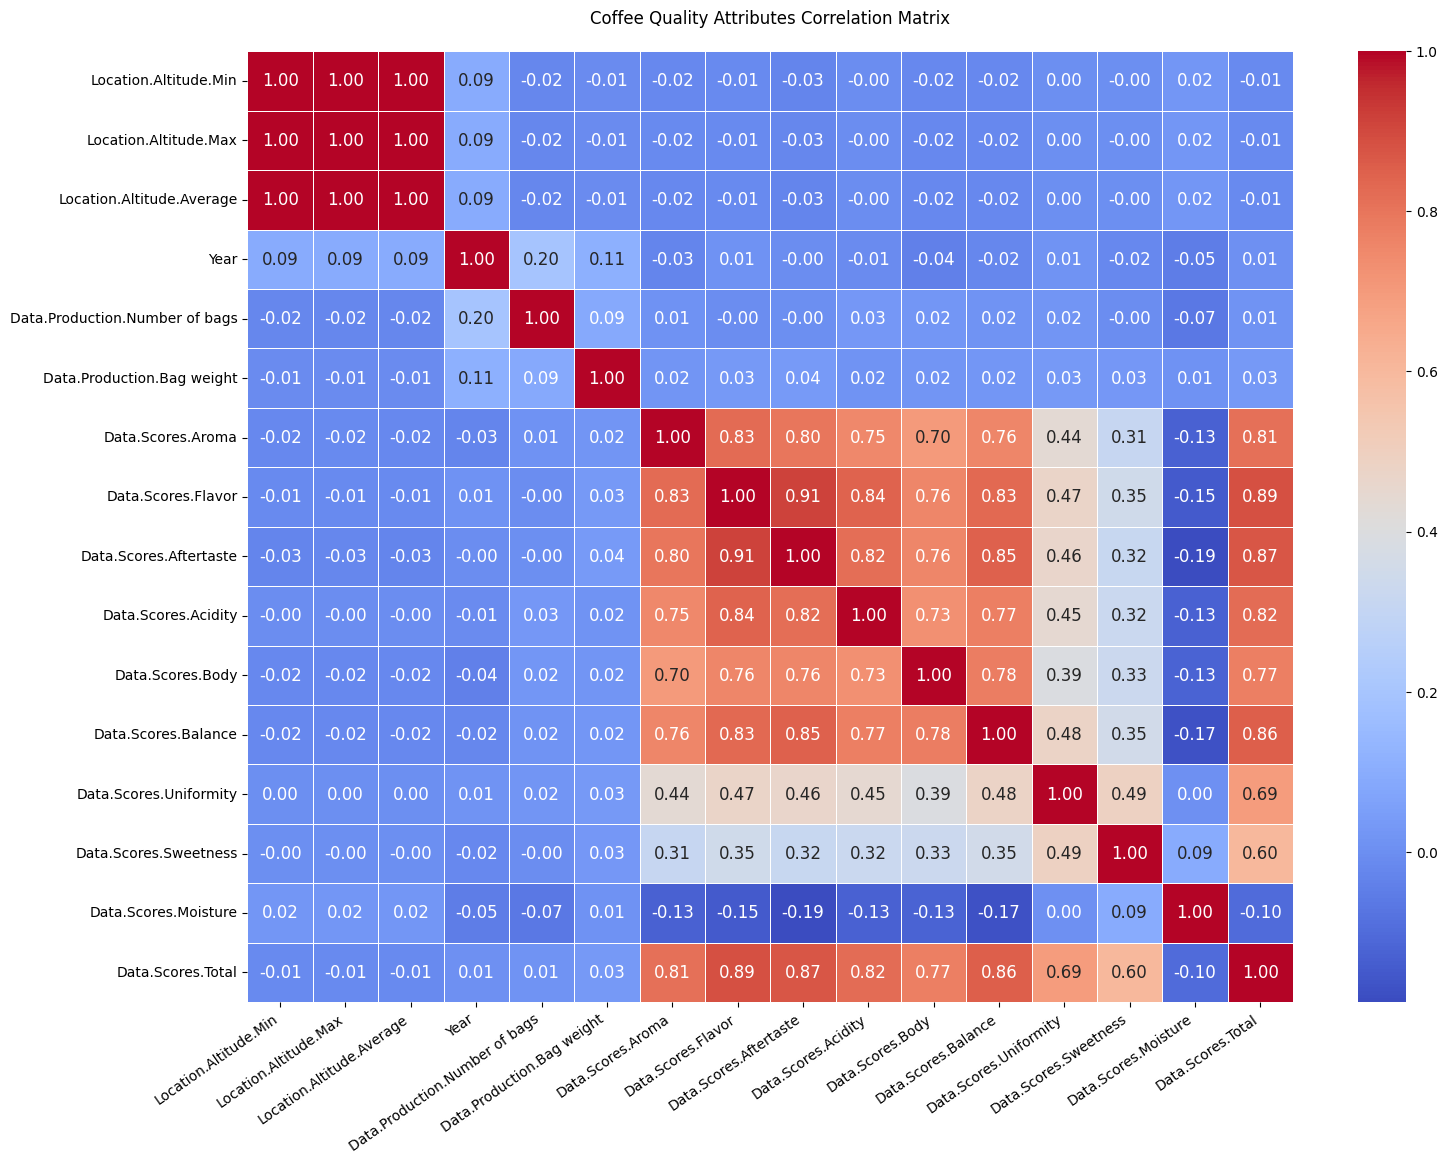

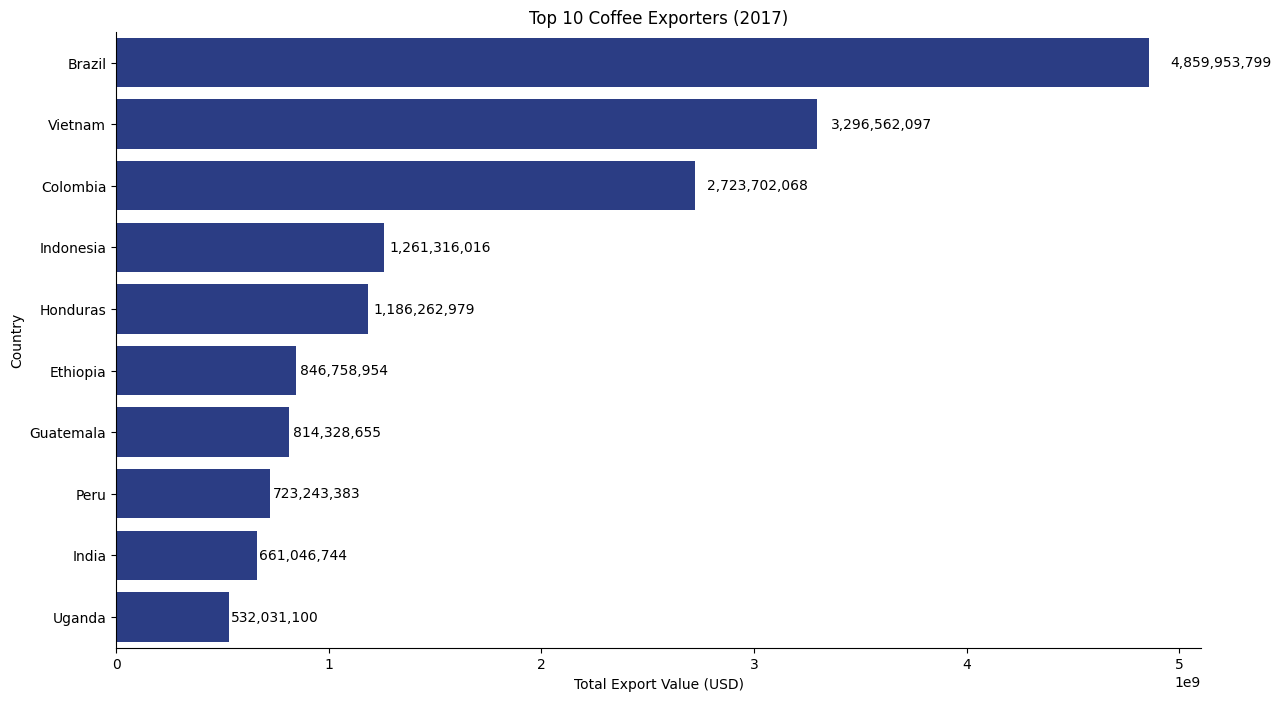

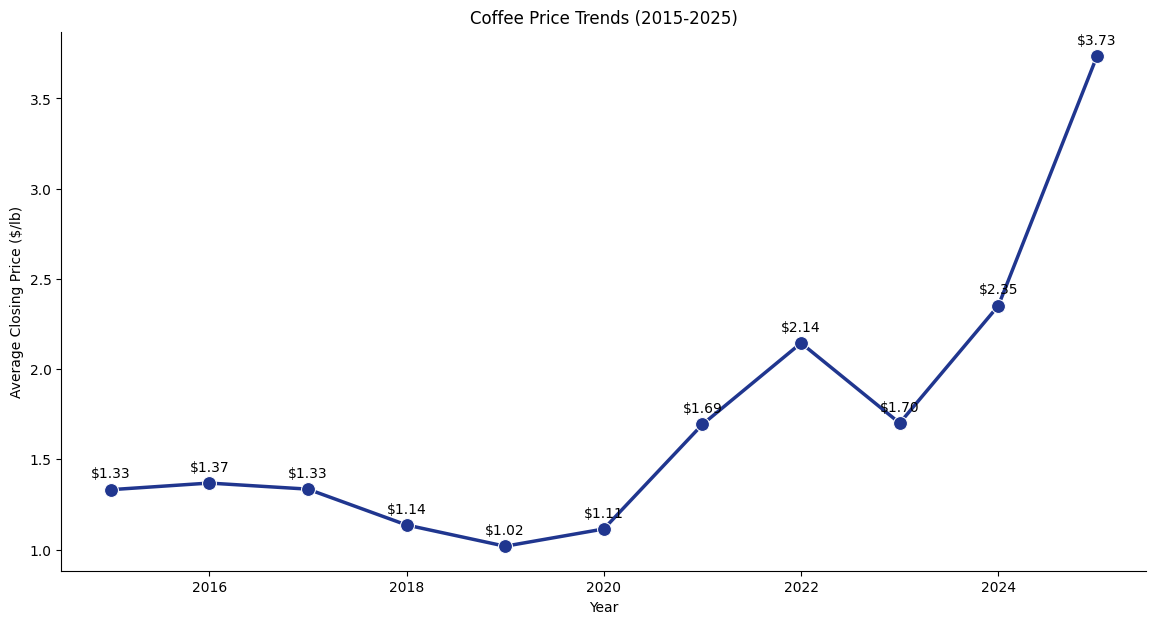

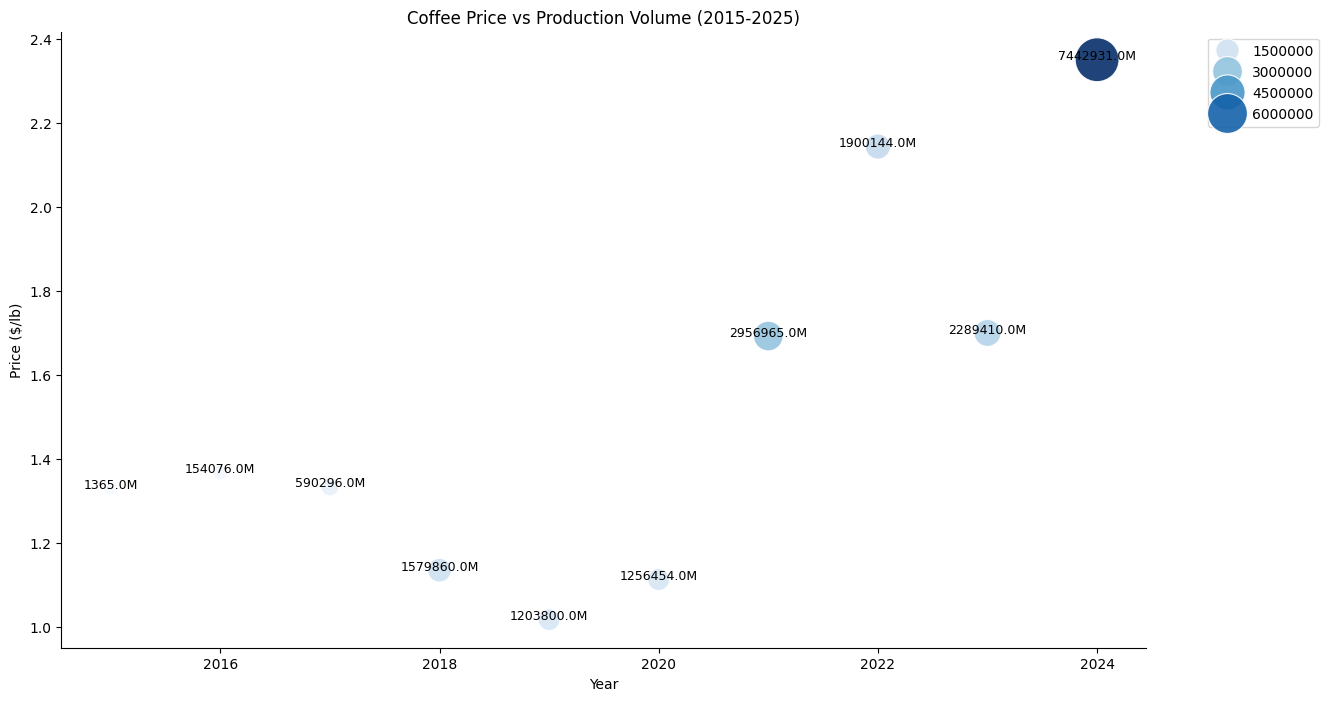

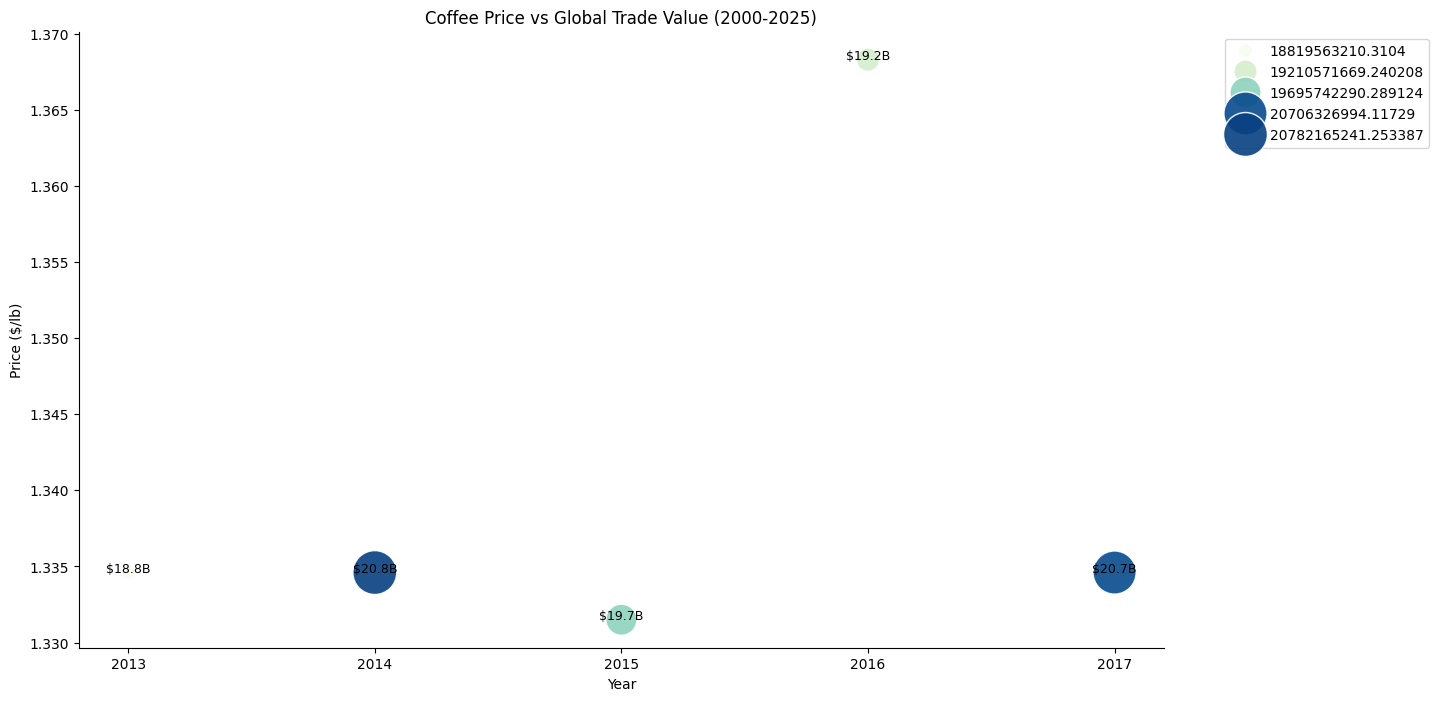

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Coffee Quality Data
coffee_quality_df = pd.read_csv("coffee.csv")

# Load Global Trade Data
trade_df = pd.read_excel(
    "resourcetradeearth-all-all-904-2017.xlsx",
    engine="openpyxl",
    sheet_name="Trades",
    header=0,
    usecols="C, G, K, L",
    names=['Exporter', 'Importer', 'Year', 'Trade Value (USD)']
)
trade_df = trade_df[
    (trade_df['Year'] >= 2000) & 
    (trade_df['Year'] <= 2025)
].dropna(subset=['Exporter', 'Importer'])
trade_df['Trade Value (USD)'] = trade_df['Trade Value (USD)'] * 1000

# USDA Production Data
production_df = pd.read_csv("psd_coffee.csv")
production_df = production_df.rename(columns={"Calendar_Year": "Year"})
production_df = production_df[
    (production_df['Market_Year'] >= 2015) &
    (production_df['Market_Year'] <= 2025)
]
production_trend = production_df.groupby('Year')['Value'].sum().reset_index()

# Price Data
price_data = {
    'Year': [2025, 2024, 2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015],
    'Average Closing Price': [3.7340, 2.3509, 1.7006, 2.1443, 1.6933, 1.1138, 1.0182, 1.1360, 1.3346, 1.3683, 1.3315],
    'Annual % Change': [22.28, 63.42, 17.43, -26.14, 76.30, -1.12, 27.34, -19.29, -7.92, 8.17, -23.95]
}
price_df = pd.DataFrame(price_data)

# Merge Data
merged_prod_price = pd.merge(production_trend, price_df, on='Year', how='left')
trade_by_year = trade_df.groupby('Year')['Trade Value (USD)'].sum().reset_index()
merged_trade_price = pd.merge(trade_by_year, price_df, on='Year', how='left')

# Handle Missing Data
for df in [coffee_quality_df, trade_df, production_df, merged_prod_price, merged_trade_price]:
    num_cols = df.select_dtypes(include=['number']).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())
    cat_cols = df.select_dtypes(include=['object']).columns
    for col in cat_cols:
        df[col] = df[col].fillna(df[col].mode()[0])

# Custom Color Palette
MAIN_COLOR = '#20368F'  # Dark blue
SECONDARY_COLOR = '#23A4DB'  # Medium blue
TERTIARY_COLOR = '#000000'  # Darker blue

# Visualization 1: Aroma Distribution
plt.figure(figsize=(12,6))
ax = sns.histplot(coffee_quality_df["Data.Scores.Aroma"], 
                 bins=20, 
                 color=MAIN_COLOR,
                 kde_kws={'color': SECONDARY_COLOR, 'linewidth': 2})

# Add exact counts to bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', 
                va='bottom',
                fontsize=10,
                color=TERTIARY_COLOR,
                xytext=(0,5),
                textcoords='offset points')

plt.title("Distribution of Coffee Aroma Scores (2015-2025)")
plt.xlabel("Aroma Score")
plt.ylabel("Count")
sns.despine()
plt.show()

# Visualization 2: Production Trends
plt.figure(figsize=(14,7))
ax = sns.lineplot(data=production_trend, 
                 x='Year', 
                 y='Value', 
                 marker='o',
                 linewidth=2.5,
                 markersize=10,
                 color=MAIN_COLOR)

# Add value labels
for x, y in zip(production_trend['Year'], production_trend['Value']):
    ax.text(x, y+1, f'{y:.1f}', 
            ha='center', 
            va='bottom',
            color=TERTIARY_COLOR,
            fontsize=10)

plt.title("Global Coffee Production Trends (2015-2025)")
plt.ylabel("Production (Million 60kg Bags)")
plt.xticks(range(2015, 2026))
sns.despine()
plt.show()

# Visualization 3: Correlation Matrix
# Define numeric columns first
numeric_cols = coffee_quality_df.select_dtypes(include=['number']).columns.tolist()

plt.figure(figsize=(16, 12))  # Increased figure size
sns.heatmap(coffee_quality_df[numeric_cols].corr(), 
            annot=True, 
            cmap="coolwarm", 
            fmt=".2f",
            linewidths=.5,
            annot_kws={"size": 12})
plt.title("Coffee Quality Attributes Correlation Matrix", pad=20)
plt.xticks(rotation=35, ha='right')  # Changed rotation and alignment
plt.yticks(rotation=0)
plt.tight_layout(pad=2)  # Added padding
plt.show()

# Visualization 4: Top Exporters 
latest_trade_year = trade_df['Year'].max()
trade_latest = trade_df[trade_df['Year'] == latest_trade_year]
top_exporters = trade_latest.groupby('Exporter')['Trade Value (USD)'].sum().nlargest(10)

if not trade_latest.empty:
    plt.figure(figsize=(14,8))
    ax = sns.barplot(x=top_exporters.values, 
                    y=top_exporters.index,
                    color=MAIN_COLOR,
                    saturation=0.8)
    
    # Value labels
    for p in ax.patches:
        width = p.get_width()
        ax.text(width + (0.02*width),
                p.get_y() + p.get_height()/2,
                f'{width:,.0f}',
                ha='left', 
                va='center',
                color=TERTIARY_COLOR,
                fontsize=10)
    
    plt.title(f"Top 10 Coffee Exporters ({int(latest_trade_year)})")
    plt.xlabel("Total Export Value (USD)")
    plt.ylabel("Country")
    sns.despine()
    plt.show()

# Visualization 5: Price Trends
plt.figure(figsize=(14,7))
ax = sns.lineplot(data=price_df, 
                 x='Year', 
                 y='Average Closing Price',
                 marker='o',
                 linewidth=2.5,
                 markersize=10,
                 color=MAIN_COLOR)

# Price labels
for x, y in zip(price_df['Year'], price_df['Average Closing Price']):
    ax.text(x, y+0.05, f'${y:.2f}', 
            ha='center', 
            va='bottom',
            color=TERTIARY_COLOR,
            fontsize=10)

plt.title("Coffee Price Trends (2015-2025)")
plt.ylabel("Average Closing Price ($/lb)")
sns.despine()
plt.show()

# Visualization 6: Price vs Production Bubble
plt.figure(figsize=(14,8))
ax = sns.scatterplot(data=merged_prod_price,
                    x='Year',
                    y='Average Closing Price',
                    size='Value',
                    sizes=(100, 1000),
                    hue='Value',
                    palette="Blues",  # Blue sequential palette
                    alpha=0.9)

# Bubble labels
for line in range(len(merged_prod_price)):
    ax.text(merged_prod_price.Year.iloc[line],
            merged_prod_price['Average Closing Price'].iloc[line],
            f"{merged_prod_price.Value.iloc[line]:.1f}M",
            horizontalalignment='center',
            color=TERTIARY_COLOR,
            fontsize=9)

plt.title("Coffee Price vs Production Volume (2015-2025)")
plt.xlabel("Year")
plt.ylabel("Price ($/lb)")
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Visualization 7: Price vs Trade Value Bubble 
plt.figure(figsize=(14,8))
ax = sns.scatterplot(data=merged_trade_price,
                    x='Year',
                    y='Average Closing Price',
                    size='Trade Value (USD)',
                    sizes=(100, 1000),
                    hue='Trade Value (USD)',
                    palette="GnBu",
                    alpha=0.9)

# Convert years to integers and set proper x-ticks
min_year = int(merged_trade_price['Year'].min())
max_year = int(merged_trade_price['Year'].max())
ax.set_xticks(range(min_year, max_year + 1))  # Only integer years
ax.set_xticklabels(range(min_year, max_year + 1))

# Bubble labels
for line in range(len(merged_trade_price)):
    ax.text(merged_trade_price.Year.iloc[line],
            merged_trade_price['Average Closing Price'].iloc[line],
            f"${merged_trade_price['Trade Value (USD)'].iloc[line]/1e9:.1f}B",
            horizontalalignment='center',
            color=TERTIARY_COLOR,
            fontsize=9)

plt.title("Coffee Price vs Global Trade Value (2000-2025)")
plt.xlabel("Year")
plt.ylabel("Price ($/lb)")
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()